# [实验二报告](https://github.com/YuweiWen1217/2024-MachineLearning)
文昱韦 2213125

#### 实验二：回归模型
将数据集winequality-white.csv按照4:1划分为训练集和测试集。
1. 初级要求：构造线性回归模型，并采用批量梯度下降和随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线；对于批量梯度下降和随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。特别需要注意：划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式；需要对数据集进行一定的预处理
2. 中级要求：探究回归模型在机器学习和统计学上的差异。回归模型在机器学习领域和统计学领域中都十分常用，而且使用方法也相似，但其实际的含义具有本质的区别。我们希望同学们从回归模型的角度更加充分地理解机器学习和统计学的区别。
3. 高级要求：编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法**均可**）。

首先导入相关工具包。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### 初级要求

首先是数据预处理和数据划分部分。主要做了四件事：对数据进行读取；按4:1划分训练集和测试集；将数据标准化（均值为0、方差为1）；为所有样本添加一个值为1的特征。

其中对于将数据标准化的部分，一般有两种做法：一种是先将所有数据标准化后，再进行训练集和测试集的划分；另一种是先进行数据集的划分，再对训练集进行标准化，将训练集标准化的参数直接应用于测试集上。实验指导书中，应用的是第一种做法，但考虑到工程实际情况，应用第二种是更合理的。本次实验采用的是第二种。

为所有样本添加一个值为1的特征为了将回归方程中的常数项也纳入参数向量中。


In [2]:
data = pd.read_csv('winequality-white.csv')
X = data.drop('quality', axis=1)
y = data['quality']
y = y.values.reshape(-1, 1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1)))) 
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

为了完成两种求解方法的线性回归，我们实现了一个线性回归模型类 `LinearRegression`，该类支持批量梯度下降和随机梯度下降两种训练方法（通过`method`成员变量控制）。


`fit` 负责根据输入的训练集进行训练。

##### 批量梯度下降
选择批量梯度下降时，模型会计算当前权重下的预测值，并与真实值计算均方误差，并计算损失函数的梯度，依据学习率更新权重参数：
$$
\theta = \theta - \alpha \cdot \frac{1}{m} X^T (X\theta - y)
$$
其中， $\theta$ 是模型参数向量，$\alpha$ 是学习率，$m$是训练样本的数量，$X$是输入特征矩阵，$y$ 是标签向量。


##### 随机梯度下降
选择随机梯度下降时，模型循环地对每个样本进行迭代更新。计算每个样本的预测值和均方误差，求得梯度并更新权重。如果迭代的均方误差变化小于设定的阈值，则结束训练。
$$
\theta = \theta - \alpha \cdot (X_i^T \cdot (X_i \theta - y_i))
$$
其中，$\theta$ 是模型参数向量，$\alpha$是学习率，$X_i$ 是第 $i$ 个样本的特征向量，$y_i$ 是第$i$个样本的真实值。


In [3]:

class LinearRegression:
    def __init__(self, learning_rate=0.1, iterations=1000, method = None):
        # 初始化线性回归模型的参数
        self.learning_rate = learning_rate
        self.iterations = iterations 
        self.theta = None
        self.method = method
        self.mse_history = []

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.random.randn(n, 1)
        self.mse_history = [] 

        # 批量梯度下降
        if self.method == 'batch':
            # 迭代训练模型
            for _ in range(self.iterations):
                predictions = X.dot(self.theta)  # 计算当前权重下的预测值
                errors = predictions - y  # 计算预测值与真实值之间的误差
                mse = np.mean(errors ** 2)  # 计算当前的均方误差
                self.mse_history.append(mse)  # 保存均方误差到历史记录中
                gradient = (1/m) * X.T.dot(errors)  # 计算损失函数相对于权重的梯度
                self.theta -= self.learning_rate * gradient  # 更新权重参数
        
        # 随机梯度下降
        elif self.method == 'stochastic':
            last_mse = 1000
            epsilon=1e-4
            isComplete = False
            for _ in range(self.iterations):
                for i in range(m):
                    xi = X[i:i+1]
                    yi = y[i, 0]
                    prediction = xi.dot(self.theta)
                    error = prediction - yi
                    mse = np.mean(error ** 2)
                    if abs(mse - last_mse) < epsilon:
                        isComplete = True
                        break
                    else:
                        last_mse = mse
                    gradient = xi.T.dot(error)
                    self.theta -= self.learning_rate * gradient
                    self.mse_history.append(mse)
                if isComplete:
                    break
        else:
            raise ValueError("Invalid method. Choose 'batch' or 'stochastic'.")
    
    def predict(self, X):
        predictions = X.dot(self.theta)
        return predictions

为了找到较好的学习率，我们定义了一组值，分别为 0.001、0.005、0.01、0.05、0.1 和 0.5。对每个学习率，我们创建 LinearRegression 模型实例，使用当前学习率、1000 次迭代以及批量梯度下降方法，并调用 fit 方法对模型进行训练，拟合训练数据，记录每次迭代的均方误差，将其绘制在同一图表上，以便进行比较。

批量梯度下降
学习率 0.001  | 训练集mse: 4.8987  | 测试集mse: 4.7898
学习率 0.005  | 训练集mse: 0.5852  | 测试集mse: 0.5857
学习率 0.01  | 训练集mse: 0.5931  | 测试集mse: 0.5878
学习率 0.05  | 训练集mse: 0.5666  | 测试集mse: 0.5654
学习率 0.1  | 训练集mse: 0.5640  | 测试集mse: 0.5612
学习率 0.5  | 训练集mse: 0.5638  | 测试集mse: 0.5616
最佳学习率为：0.1 | 对应测试集mse为: 0.5612


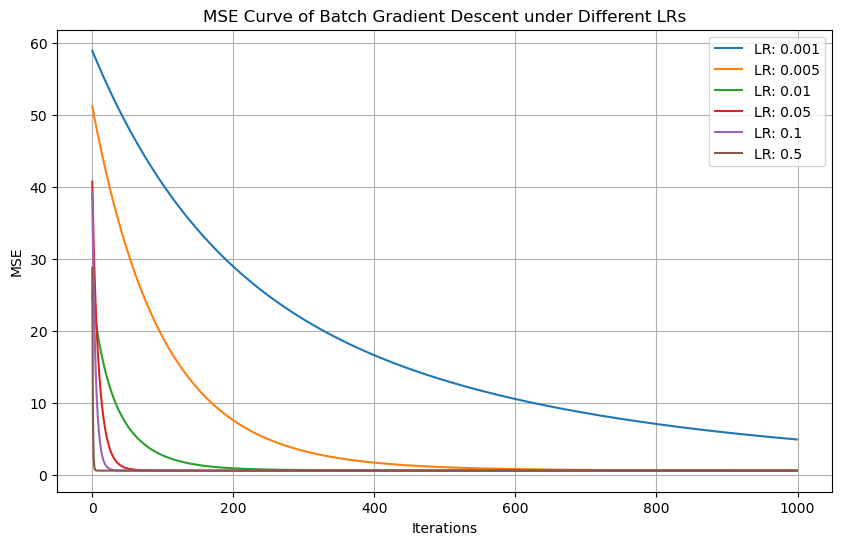

In [5]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
print('批量梯度下降')
plt.figure(figsize=(10, 6))
best_lr = -1
best_test_mse = 100
for lr in learning_rates:
    model = LinearRegression(learning_rate=lr, iterations=1000, method='batch')
    model.fit(X_train, y_train)
    plt.plot(model.mse_history, label=f'LR: {lr}')
    mse_train = np.mean((model.predict(X_train) - y_train) ** 2)
    mse_test = np.mean((model.predict(X_test) - y_test) ** 2)
    print(f'学习率 {lr}  | 训练集mse: {mse_train:.4f}  | 测试集mse: {mse_test:.4f}')
    if mse_test < best_test_mse:
        best_test_mse = mse_test
        best_lr = lr
print(f'最佳学习率为：{best_lr} | 对应测试集mse为: {best_test_mse:.4f}')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE Curve of Batch Gradient Descent under Different LRs')
plt.legend()
plt.grid()
plt.show()

#### 结果分析
从图中可以看出，学习率越大，收敛得越快，较大的学习率（如 0.05、0.1 、0.5）使模型在初始阶段迅速接近最优解，显示出快速的收敛趋势；相对而言，学习率最小的 0.001 在迭代过程中收敛速度极慢，直到迭代结束仍未达到收敛。这表明小学习率虽然在理论上能提供更精细的参数调整，但在实际应用中需要更多的迭代次数才能有效收敛。除了 0.001，其余五个学习率在均方误差的表现上相对接近，显示出它们在一定范围内都能有效地优化模型。根据运行的结果，选择0.01最优，但受到数据集划分的随机性影响，选择其余几个最后mse相似的学习率也是有可能的。

对于**随机梯度下降**的学习率设置，经过前期测试，当学习率大于0.1时，会发生数据溢出，因此学习率应该往小的方向寻找，我们设置0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05六个学习率进行寻找。

随机梯度下降
学习率 0.0001  | 训练集mse: 5.0464  | 测试集mse: 4.9382
学习率 0.0005  | 训练集mse: 0.7869  | 测试集mse: 0.7670
学习率 0.001  | 训练集mse: 1.5582  | 测试集mse: 1.4573
学习率 0.005  | 训练集mse: 0.5729  | 测试集mse: 0.5690
学习率 0.01  | 训练集mse: 0.6340  | 测试集mse: 0.6311
学习率 0.05  | 训练集mse: 0.6518  | 测试集mse: 0.6513
最佳学习率为：0.005 | 对应测试集mse为: 0.5690


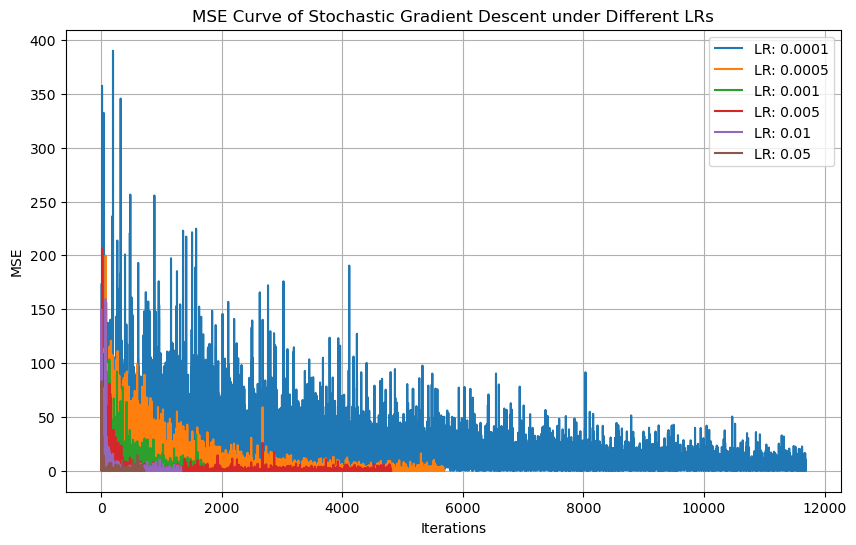

In [8]:
print('随机梯度下降')
# 定义不同的学习率
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
best_lr = -1
best_test_mse = 100
# 绘制每个学习率的训练曲线
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    # 初始化模型
    model = LinearRegression(learning_rate=lr, iterations=1000, method='stochastic')
    model.fit(X_train, y_train)
    # 绘制当前学习率的MSE历史
    plt.plot(model.mse_history, label=f'LR: {lr}')
    mse_train = np.mean((model.predict(X_train) - y_train) ** 2)
    mse_test = np.mean((model.predict(X_test) - y_test) ** 2)
    print(f'学习率 {lr}  | 训练集mse: {mse_train:.4f}  | 测试集mse: {mse_test:.4f}')
    if mse_test < best_test_mse:
        best_test_mse = mse_test
        best_lr = lr
print(f'最佳学习率为：{best_lr} | 对应测试集mse为: {best_test_mse:.4f}')
# 绘制图形
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE Curve of Stochastic Gradient Descent under Different LRs')
plt.legend()
plt.grid()
plt.show()

#### 结果分析

从图中可以看出，学习率越大，模型收敛得越快。例如，当学习率为 0.05 时，模型在不到 1000 次迭代内就完成了收敛；学习率为 0.0001 时，模型几乎接近 12000 次迭代才收敛，且最终的指标表现并不理想。与批量梯度下降相比，随机梯度下降的均方误差波动较大，表明其更新步骤受单个样本的影响较大，导致在收敛过程中表现出更大的波动。根据测试结果，最佳学习率被确定为 0.005，但需要注意的是，最佳学习率的选择仍然受到数据集划分、初始参数的生成等随机性的影响。

### 中级要求

统计学中回归系数的计算是通过解析解的方式完成的：
$$
    \theta = (X^TX)^{-1}X^Ty
$$

使用这个方法，需要满足$X^TX$是满秩矩阵，因此，在使用时需要进行检查，否则无法进行求解。（一种解决方法是添加正则项，即高级要求中的相关内容）

我们使用直接解方程和批量梯度下降两种方法对比来看：

In [9]:
def calculate_theta(X, y):
    try:
        XtX = X.T.dot(X)
        if np.linalg.matrix_rank(XtX) < min(X.shape):
            raise ValueError("X不是满秩矩阵")
        theta = np.linalg.inv(XtX).dot(X.T).dot(y)
        return theta
    except np.linalg.LinAlgError:
        print("矩阵不可逆，无法计算 theta。")
    except ValueError as e:
        print(e)

theta = calculate_theta(X_train, y_train)
theta = theta.reshape(-1)
if theta is not None:
    np.set_printoptions(precision=4, suppress=True)
    print("直接求解得到的theta:", theta)
    predictions = X_train.dot(theta)
    train_mse = np.mean((predictions - y_train) ** 2) 
    predictions = X_test.dot(theta)
    test_mse = np.mean((predictions - y_test) ** 2)
    print(f'train mse:{train_mse:.4f} | test mse:{test_mse:.4f}')

print()
model = LinearRegression(learning_rate=0.1, iterations=1000, method='batch')
model.fit(X_train, y_train)
mse_train  = np.mean((model.predict(X_train) - y_train) ** 2)
mse_test = np.mean((model.predict(X_test) - y_test) ** 2)
theta = model.theta
theta = theta.reshape(-1)
np.set_printoptions(precision=4, suppress=True)
print("迭代求解得到的theta:", theta)
print(f'train mse:{mse_train:.4f} | test mse:{mse_test:.4f}')



直接求解得到的theta: [ 0.0522 -0.197   0.0016  0.4015 -0.0007  0.0529 -0.0033 -0.425   0.1053
  0.0704  0.2516  5.878 ]
train mse:1.0042 | test mse:1.0011

迭代求解得到的theta: [ 0.0314 -0.1992  0.0004  0.3422 -0.0038  0.0567 -0.0073 -0.334   0.0879
  0.0654  0.2944  5.878 ]
train mse:0.5641 | test mse:0.5625


##### 分析
通过直接解方程和批量迭代下降两种方法，我们得到了相应的模型参数和均方误差（MSE）指标。结果表明，直接解法（统计学）虽然能够给出精确的参数，但在误差指标上并未表现出最佳性能。相较之下，使用批量迭代下降法训练集和测试集的均方误差显著降低，分别为 0.5641 和 0.5625。、

从回归模型的角度来看，机器学习与统计学的本质区别在于参数估计的方法和意义。统计学上，通过解矩阵直接获得参数，强调模型的可解释性，即“为什么是这个参数”“参数为什么这么取值”等。而机器学习则倾向于使用迭代算法来优化模型参数，关注的是模型的预测性能，而不那么注重解释性。

再回到这个结果，统计学方法虽然给出了一个理论上的最优解，但由于其对数据的局限性、过拟合等可能的原因，导致其在训练和测试上的均方误差均较高，而批量迭代法则通过反复调整参数，能够更有效地减少误差，**获得了更好的预测能力**。

### 高级要求


岭回归的损失函数表示如下：

$$
L(\theta) = \frac{1}{m} \| y - X\theta \|^2 + \alpha \|\theta\|^2
$$

其中,
$ m $ 是样本数量，
$ y $ 是目标变量的向量，
$ X $ 是特征矩阵，
$ \theta $ 是回归系数的向量，
$ \alpha $ 是正则化参数。
$ \|\theta\|^2 $ 是参数向量的 L2 正则化范数。

对该方程求$ \theta $的偏导数，再令其等于0，可求得：
$$
\theta = (X^T X + \alpha I)^{-1} X^T y
$$
$ \theta $即为所求


根据前期实验，正则化参数在小于10的范围内表现都比较好，在小于1时表现比较稳定，我们最后选择了0.1作为正则化参数。

In [10]:
def ridge_regression(X, y, alpha):
    m, n = X.shape
    I = np.eye(n)
    theta = np.linalg.inv(X.T.dot(X) + alpha * I).dot(X.T).dot(y)
    return theta


def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

alpha = 0.1
theta_ridge = ridge_regression(X_train, y_train, alpha)
y_train_pred = X_train.dot(theta_ridge)
y_test_pred = X_test.dot(theta_ridge)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"岭回归(alpha = 0.1)训练误差: {train_mse:.4f}, 测试误差: {test_mse:.4f}")

岭回归(alpha = 0.1)训练误差: 0.5638, 测试误差: 0.5616
